In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

In [3]:
## Step 1: Load and prepare our data
start_date = '2020-01-01'
end_date = '2024-01-01'

print(f"Loading data from {start_date} to {end_date}")

tickers = ['SPY', 'EEM', 'GLD']
etf_raw = yf.download(tickers, start=start_date, end=end_date)
etf_data = etf_raw['Close']

vix_raw = yf.download('^VIX', start=start_date, end=end_date)
vix_data = vix_raw['Close']

dxy_raw = yf.download('DX-Y.NYB', start=start_date, end=end_date)
dxy_data = dxy_raw['Close']

# Combine into main dataset
df = pd.DataFrame(index=etf_data.index)
df['SPY'] = etf_data['SPY']
df['EEM'] = etf_data['EEM'] 
df['GLD'] = etf_data['GLD']
df['VIX'] = vix_data.values  # .values to avoid index mismatch
df['DXY'] = dxy_data.values

print(f"Data loaded. Shape: {df.shape}")
print(f"Date range: {df.index.min().date()} to {df.index.max().date()}")

Loading data from 2020-01-01 to 2024-01-01


[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Data loaded. Shape: (1006, 5)
Date range: 2020-01-02 to 2023-12-29


In [4]:
## Step 2: Calculate the features we need for regime classification

# Calculate daily returns
for asset in ['SPY', 'EEM', 'GLD', 'DXY']:
    df[f'{asset}_return'] = df[asset].pct_change()

# Calculate DXY 50-day Rate of Change (ROC)
# ROC = (Current Price - Price 50 days ago) / Price 50 days ago
df['DXY_50d_ROC'] = df['DXY'].pct_change(periods=50)

print("Features calculated:")
print(f"- Daily returns for SPY, EEM, GLD, DXY")
print(f"- DXY 50-day Rate of Change")

# Basic stats
print(f"\nDXY 50-day ROC stats:")
print(df['DXY_50d_ROC'].describe().round(4))

Features calculated:
- Daily returns for SPY, EEM, GLD, DXY
- DXY 50-day Rate of Change

DXY 50-day ROC stats:
count    956.0000
mean       0.0038
std        0.0328
min       -0.0936
25%       -0.0191
50%        0.0074
75%        0.0270
max        0.0829
Name: DXY_50d_ROC, dtype: float64


In [5]:
## Step 3: Calculate VIX percentiles for regime thresholds
# We need the 25th and 75th percentiles of VIX to define regimes
vix_25th = df['VIX'].quantile(0.25)
vix_75th = df['VIX'].quantile(0.75)

print(f"\nVIX Thresholds:")
print(f"25th percentile (low volatility): {vix_25th:.2f}")
print(f"75th percentile (high volatility): {vix_75th:.2f}")


VIX Thresholds:
25th percentile (low volatility): 17.28
75th percentile (high volatility): 26.29


In [6]:
## Step 4: Define the Dollar Smile regimes
def classify_regime(row):
    """
    Classify each day into one of four Dollar Smile regimes:
    1. Risk-Off Dollar Strength: VIX > 75th percentile AND DXY 50-day ROC > 0
    2. Pro-Growth Dollar Strength: VIX < 25th percentile AND DXY 50-day ROC > 0  
    3. Dollar Weakness: DXY 50-day ROC < 0
    4. Neutral/Sideways: Everything else
    """
    vix = row['VIX']
    dxy_roc = row['DXY_50d_ROC']
    
    if pd.isna(vix) or pd.isna(dxy_roc):
        return 'Missing Data'
    
    # Regime 1: Risk-Off Dollar Strength
    if vix > vix_75th and dxy_roc > 0:
        return 'Risk-Off Dollar Strength'
    
    # Regime 2: Pro-Growth Dollar Strength  
    elif vix < vix_25th and dxy_roc > 0:
        return 'Pro-Growth Dollar Strength'
    
    # Regime 3: Dollar Weakness
    elif dxy_roc < 0:
        return 'Dollar Weakness'
    
    # Regime 4: Everything else
    else:
        return 'Neutral/Sideways'

# Apply the classification
df['Regime'] = df.apply(classify_regime, axis=1)

In [7]:
## Step 5: Look at regime distribution
regime_counts = df['Regime'].value_counts()
print(f"\nRegime Distribution:")
print(regime_counts)
print(f"\nAs percentages:")
print((regime_counts / len(df) * 100).round(1))


Regime Distribution:
Regime
Dollar Weakness               394
Neutral/Sideways              266
Risk-Off Dollar Strength      168
Pro-Growth Dollar Strength    128
Missing Data                   50
Name: count, dtype: int64

As percentages:
Regime
Dollar Weakness               39.2
Neutral/Sideways              26.4
Risk-Off Dollar Strength      16.7
Pro-Growth Dollar Strength    12.7
Missing Data                   5.0
Name: count, dtype: float64


Available regimes: ['Missing Data' 'Risk-Off Dollar Strength' 'Dollar Weakness'
 'Neutral/Sideways' 'Pro-Growth Dollar Strength']


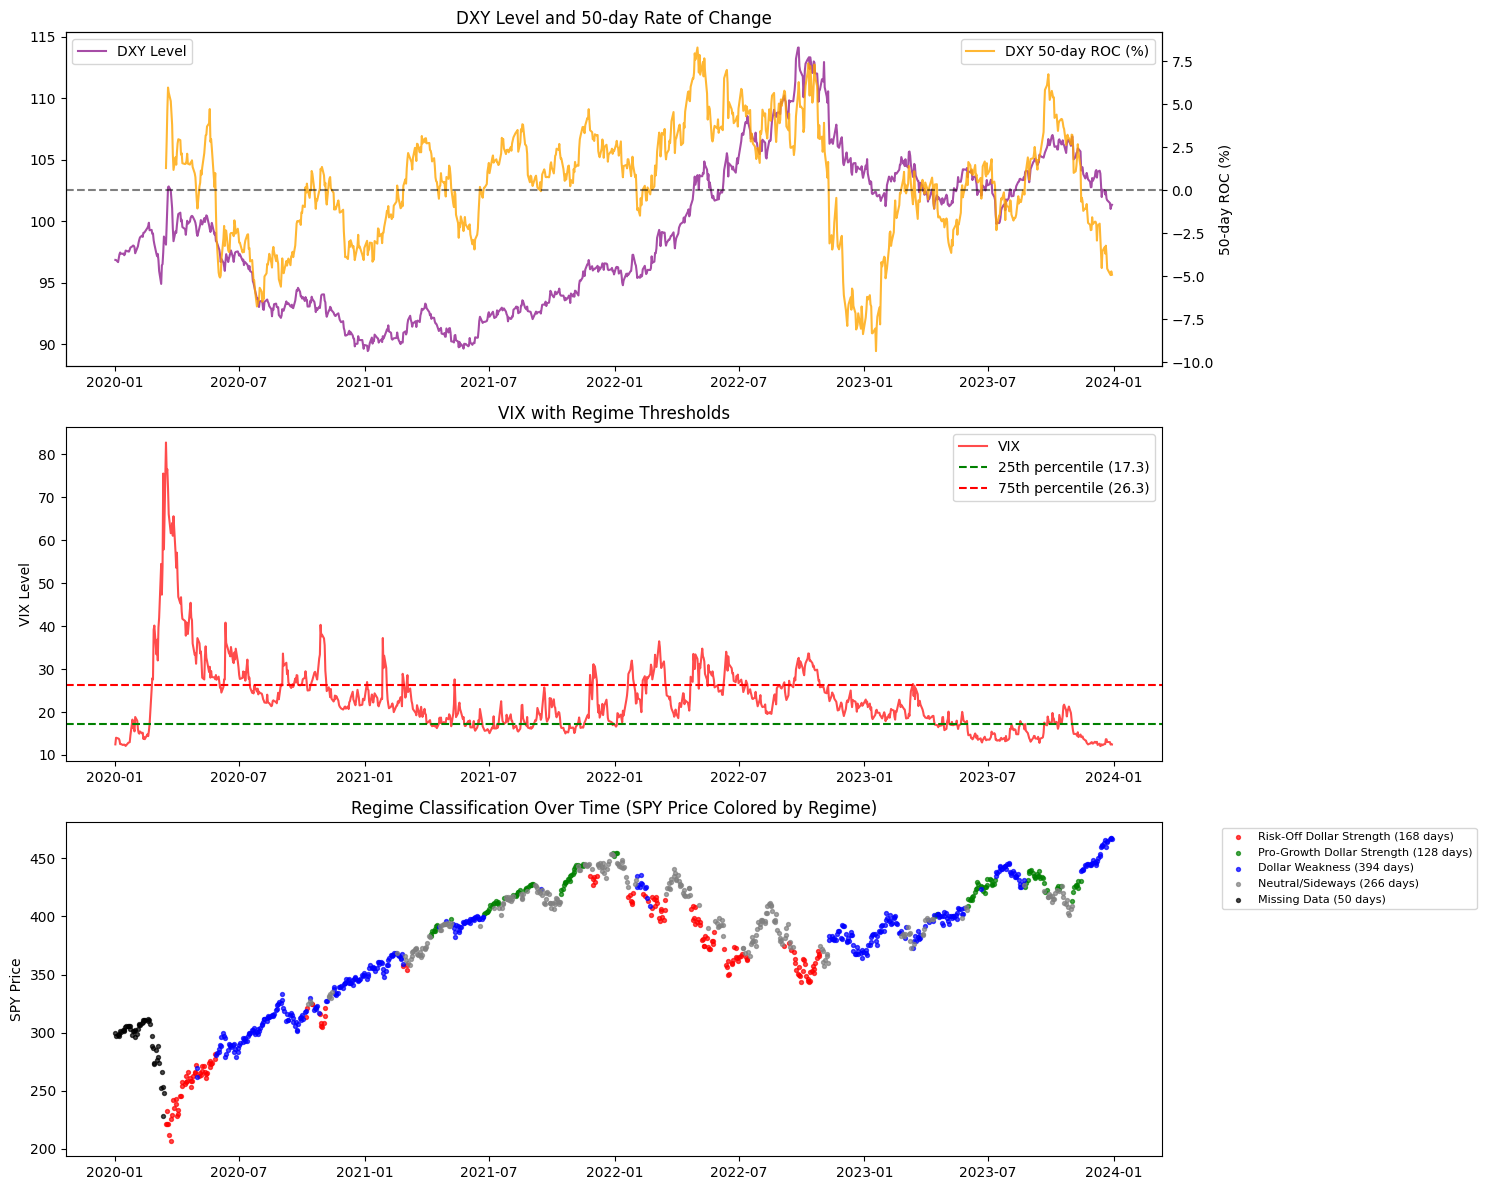

In [8]:
## Step 6: Visualize the regimes over time
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Plot 1: DXY with 50-day ROC
axes[0].plot(df.index, df['DXY'], label='DXY Level', color='purple', alpha=0.7)
ax_twin = axes[0].twinx()
ax_twin.plot(df.index, df['DXY_50d_ROC'] * 100, label='DXY 50-day ROC (%)', color='orange', alpha=0.8)
ax_twin.axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[0].set_title('DXY Level and 50-day Rate of Change')
axes[0].legend(loc='upper left')
ax_twin.legend(loc='upper right')
ax_twin.set_ylabel('50-day ROC (%)')

# Plot 2: VIX with regime thresholds
axes[1].plot(df.index, df['VIX'], label='VIX', color='red', alpha=0.7)
axes[1].axhline(y=vix_25th, color='green', linestyle='--', label=f'25th percentile ({vix_25th:.1f})')
axes[1].axhline(y=vix_75th, color='red', linestyle='--', label=f'75th percentile ({vix_75th:.1f})')
axes[1].set_title('VIX with Regime Thresholds')
axes[1].legend()
axes[1].set_ylabel('VIX Level')

# Plot 3: Regime timeline 
print("Available regimes:", df['Regime'].unique())

# Create a colored timeline
regime_colors = {
    'Risk-Off Dollar Strength': 'red',
    'Pro-Growth Dollar Strength': 'green', 
    'Dollar Weakness': 'blue',
    'Neutral/Sideways': 'gray',
    'Missing Data': 'black'
}

for regime, color in regime_colors.items():
    mask = df['Regime'] == regime
    if mask.sum() > 0: 
        axes[2].scatter(df.index[mask], df['SPY'][mask], 
                       label=f'{regime} ({mask.sum()} days)', 
                       color=color, alpha=0.7, s=8)

axes[2].set_title('Regime Classification Over Time (SPY Price Colored by Regime)')
axes[2].set_ylabel('SPY Price')
axes[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()
